In [4]:
import os

annotations_path = "Data/annotations"
corrected_annotations_path = "Data/annotations_corrected"

# Create directory for corrected annotations
os.makedirs(corrected_annotations_path, exist_ok=True)

# Function to correct annotation files
def correct_annotations(file_path, save_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    corrected_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        # Check if class_id is within the valid range (0)
        if class_id == 0:  # Assuming valid class_id is 0 for a single class
            corrected_lines.append(line)
    
    with open(save_path, 'w') as file:
        file.writelines(corrected_lines)

# Correct all annotation files
for annotation_file in os.listdir(annotations_path):
    if annotation_file.endswith(".txt"):
        correct_annotations(
            os.path.join(annotations_path, annotation_file),
            os.path.join(corrected_annotations_path, annotation_file)
        )

print("Annotations corrected and saved to", corrected_annotations_path)


Annotations corrected and saved to Data/annotations_corrected


In [5]:
import os
import shutil
import random
from ultralytics import YOLO
import logging
import torch

# Define paths
images_path = "Data/input/images_resized"
annotations_path = "Data/annotations_corrected"  # Use corrected annotations
train_path = "Data/train"
val_path = "Data/val"

In [6]:
# Ensure the directories are created and set permissions
def create_and_set_permissions(path):
    os.makedirs(path, exist_ok=True)

create_and_set_permissions(f"{train_path}/images")
create_and_set_permissions(f"{train_path}/labels")
create_and_set_permissions(f"{val_path}/images")
create_and_set_permissions(f"{val_path}/labels")

# Move images and annotations to the appropriate directories and split into train/val sets
images = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]
random.shuffle(images)
split_ratio = 0.8
split_index = int(split_ratio * len(images))

train_images = images[:split_index]
val_images = images[split_index:]

for image_file in train_images:
    shutil.copy(os.path.join(images_path, image_file), f"{train_path}/images")
    annotation_file = os.path.splitext(image_file)[0] + ".txt"
    shutil.copy(os.path.join(annotations_path, annotation_file), f"{train_path}/labels")

for image_file in val_images:
    shutil.copy(os.path.join(images_path, image_file), f"{val_path}/images")
    annotation_file = os.path.splitext(image_file)[0] + ".txt"
    shutil.copy(os.path.join(annotations_path, annotation_file), f"{val_path}/labels")

# Verify that images exist in the validation directory
assert len(os.listdir(f"{val_path}/images")) > 0, "No images found in validation directory!"

In [ ]:
# Define YOLOv8 model and train
model = YOLO('yolov8s.pt')  # Use a smaller pre-trained YOLOv8 model

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

# Custom training function with epoch progress tracking
class CustomLogger:
    def __init__(self):
        self.epochs = 0

    def __call__(self, state):
        if state['epoch'] != self.epochs:
            self.epochs = state['epoch']
            logger.info(f"Epoch {self.epochs + 1}/{state['epochs']} - Loss: {state['loss']:.4f}, "
                        f"mAP@0.5: {state['metrics']['mAP@0.5']:.4f}, "
                        f"mAP@0.5:0.95: {state['metrics']['mAP@0.5:0.95']:.4f}")

# Attach custom logger
model.add_callback('on_epoch_end', CustomLogger())

# Define dataset configuration file
data_config = f"""
train: {os.path.abspath(train_path)}/images
val: {os.path.abspath(val_path)}/images

nc: 1  # number of classes
names: ['insect']
"""

with open('dataset.yaml', 'w') as f:
    f.write(data_config)

# Set the device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train the model
results = model.train(data='dataset.yaml', epochs=10, imgsz=128, batch=32, device=device, half=True)

# Save the model
model.save("yolov8S_insect_detection.pt")

# Show training results
print(f"Training results: {results}")

Ultralytics YOLOv8.2.28  Python-3.11.1 torch-2.2.2+cpu CPU (AMD Ryzen 7 5700U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=128, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning C:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-challenge-algorithm\Data\train\labels.cache... 39445 images, 39197 backgrounds, 2 corrupt: 100%|██████████| 39445/39445 [00:00<?, ?it/s]

train: WARNING  C:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-challenge-algorithm\Data\train\images\148_20200626004202_35760.jpg: ignoring corrupt image/label: Label class 75 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING  C:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-challenge-algorithm\Data\train\images\271_20210906005025_23469.jpg: ignoring corrupt image/label: Label class 15 exceeds dataset class count 1. Possible class labels are 0-0



val: Scanning C:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-challenge-algorithm\Data\val\labels.cache... 23259 images, 23122 backgrounds, 0 corrupt: 100%|██████████| 23259/23259 [00:00<?, ?it/s]


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs\detect\train7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      0.437      3.085       0.31          0        128: 100%|██████████| 1233/1233 [23:26<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [07:08<00:00,  1.18s/it]

                   all      23259        138          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.5125      1.071     0.3759          0        128: 100%|██████████| 1233/1233 [21:36<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:50<00:00,  1.13s/it]

                   all      23259        138    0.00376    0.00725   0.000295    5.9e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      0.488      1.033     0.3667          1        128: 100%|██████████| 1233/1233 [21:11<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:36<00:00,  1.09s/it]

                   all      23259        138    0.00376    0.00725   0.000295    5.9e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      0.456     0.9722      0.345          0        128: 100%|██████████| 1233/1233 [20:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:38<00:00,  1.10s/it]

                   all      23259        138      0.108      0.254     0.0925     0.0345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.4258     0.9324     0.3351          1        128: 100%|██████████| 1233/1233 [20:40<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:37<00:00,  1.09s/it]

                   all      23259        138     0.0833      0.138     0.0592     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.4055     0.8852     0.3101          0        128: 100%|██████████| 1233/1233 [20:40<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:36<00:00,  1.09s/it]

                   all      23259        138      0.103      0.507      0.163     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      0.397     0.8854     0.3137          0        128: 100%|██████████| 1233/1233 [20:53<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:37<00:00,  1.09s/it]

                   all      23259        138      0.194      0.217      0.173      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.3573      0.852     0.2841          0        128: 100%|██████████| 1233/1233 [20:39<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:38<00:00,  1.09s/it]

                   all      23259        138      0.133      0.428      0.192     0.0909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.3264     0.8068     0.2675          0        128: 100%|██████████| 1233/1233 [20:41<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:37<00:00,  1.09s/it]

                   all      23259        138      0.237      0.377       0.25      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.3237     0.8257     0.2711          0        128: 100%|██████████| 1233/1233 [20:37<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [06:38<00:00,  1.10s/it]

                   all      23259        138      0.131        0.5      0.224      0.119



10 epochs completed in 4.640 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics YOLOv8.2.28  Python-3.11.1 torch-2.2.2+cpu CPU (AMD Ryzen 7 5700U with Radeon Graphics)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 364/364 [05:49<00:00,  1.04it/s]


                   all      23259        138      0.237      0.377       0.25      0.133
Speed: 0.2ms preprocess, 13.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\detect\train7
Training results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D4B0987850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031


image 1/1 c:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-challenge-algorithm\Data\input\images_resized\292_20210908003816_30775.jpg: 640x640 (no detections), 267.6ms
Speed: 8.0ms preprocess, 267.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-challenge-algorithm\Data\input\images_resized\112_20200616025701_33907.jpg: 640x640 (no detections), 255.2ms
Speed: 4.8ms preprocess, 255.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-challenge-algorithm\Data\input\images_resized\294_20210825010449_15685.jpg: 640x640 (no detections), 259.6ms
Speed: 5.8ms preprocess, 259.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\Gebruiker\Documents\Fontys\S6 - AI\Personal - Data Driven Challenge\arise-cha

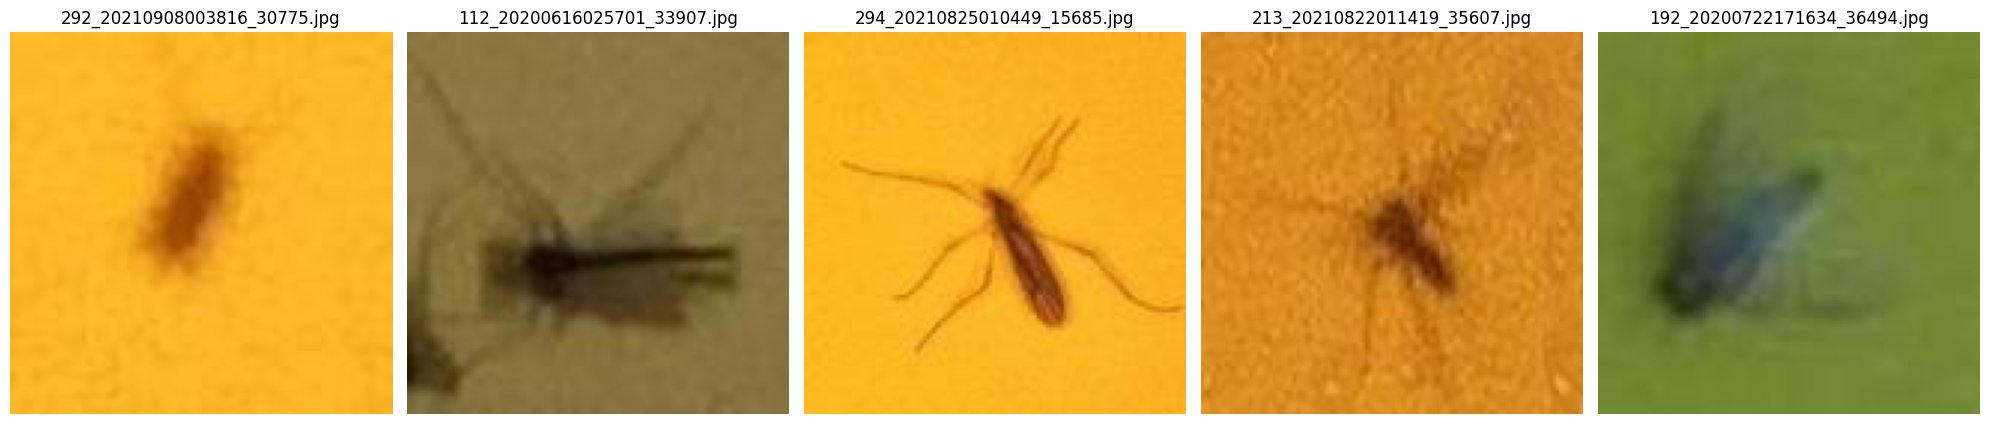

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
model = YOLO("yolov8S_insect_detection.pt")

# Define paths
images_path = "Data/input/images_resized"

# Get a list of image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

# Select a few random images to visualize
num_examples = 5
example_images = random.sample(image_files, num_examples)

# Function to run inference and display results
def get_inference_result_image(image_path):
    # Run inference on the image
    results = model(image_path)
    # Get the result image with bounding boxes
    result_image = results[0].plot()
    # Convert the image to RGB format for displaying with matplotlib
    result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    return result_image_rgb

# Create a figure to display the images
fig, axes = plt.subplots(1, num_examples, figsize=(20, 10))

# Run inference and show results for each example image
for ax, image_file in zip(axes, example_images):
    image_path = os.path.join(images_path, image_file)
    result_image = get_inference_result_image(image_path)
    ax.imshow(result_image)
    ax.axis('off')
    ax.set_title(os.path.basename(image_path))

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

def split_image_with_overlap(image, tile_size, overlap):
    h, w, _ = image.shape
    step = tile_size - overlap
    tiles = []
    for y in range(0, h, step):
        for x in range(0, w, step):
            tiles.append((x, y, image[y:y+tile_size, x:x+tile_size]))
    return tiles

def draw_boxes(image, boxes, offset_x=0, offset_y=0):
    for box in boxes:
        x1, y1, x2, y2, conf, cls = box
        x1, y1, x2, y2 = int(x1 + offset_x), int(y1 + offset_y), int(x2 + offset_x), int(y2 + offset_y)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = f"Class: {int(cls)}, Conf: {conf:.2f}"
        font_scale = 0.4  # Adjusted font scale for better readability
        thickness = 1  # Adjusted thickness for better readability
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        cv2.rectangle(image, (x1, y1 - h - 4), (x1 + w, y1), (255, 0, 0), -1)  # Background rectangle for better readability
        cv2.putText(image, label, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)
    return image

# Load the trained model
model = YOLO("yolov8S_insect_detection.pt")

# Load the image
image_path = "Data/input/20200809000003-1.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into tiles with overlap
tile_size = 128
overlap = 32  # 25% overlap
tiles = split_image_with_overlap(image_rgb, tile_size, overlap)

# Run inference on each tile and draw boxes
for x, y, tile in tiles:
    results = model(tile)
    detected_objects = results[0].boxes.data.cpu().numpy()
    draw_boxes(image_rgb, detected_objects, offset_x=x, offset_y=y)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()



0: 640x640 (no detections), 281.9ms
Speed: 6.0ms preprocess, 281.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


AttributeError: 'list' object has no attribute 'xyxy'